In [235]:
'''Libraries'''
import random
import numpy as np
from copy import deepcopy
from math import ceil, floor, sqrt
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.cm as cm
%matplotlib inline
from random import shuffle
from scipy import stats

## Crowd Egress Model ##

In [236]:
""" The Crow Egress Class is intialized with all the key parameters 

people_total is integer value that initializes the total number of people in the room
exits is an integer value that indicates the number of exits in the room
exit_size is an integer that specifies the width of exit e.g. exit_size = 2 means the exit occupies 2 blocks along the boundary
room_size is a tuple giving the width and length of the room 
room_setup is a 2D array which sets up the grid based on number of columns and rows

exit_placement is an empty array that is initialized to store the points of exit later in the code
mids is an empty array that is initialized to store the midpoints of the exit locations

"""

class Crowd_Egress():
  def __init__(self, people_total, exits, exit_size, room_size):
    self.people_total = people_total 
    self.exits = exits
    self.exit_size = exit_size
    self.room_size = room_size 
    self.room_setup = [[0 for i in range(room_size[0])] for i in range(room_size[1])]
    self.exit_placement = []
    self.mids = []
    """
    The initialize function sets up the room based on the specified parameters. 
  
    """
  def initialize(self):

    counter = 0 #This counter keeps track of all the people who need to be populated in the room

    """
    The while loop is implemented to add every person to a unique spot based
    on the dimensions of the room.
    The conditions in this loop make sure there is no other person at the coordinate already.
    
    """
    while counter != self.people_total:
      row = random.randint(0,self.room_size[1]-1)
      column = random.randint(0,self.room_size[0]-1)

      if self.room_setup[row][column] != 1:
        self.room_setup[row][column] = 1
      
        counter+= 1

    '''
    The following loop runs till the specified no. of exits have been placed on different boundaries of the room.
    The 2D room has 4 boundaries: top, bottom, right and left.
    1 = top, 2 = right , 3 = bottom , 4 = left
    '''
    for i in range(self.exits):
        
      exit_placed = False
      while exit_placed == False:
            
        #An integer generated between 1 and 4 is randomly chosen to select the boundary
        boundary = random.randint(1,4)
        if boundary == 1 or boundary == 3: #checks for top and bottom 
          exit_point = random.randint(0,self.room_size[0]-self.exit_size) #makes sure that the exit is placed along the dimension of the width

        # A check is placed to see if there is already an exit in place
          exit_exists = False
          if boundary == 1:
            for coordinates in self.exit_placement:
              for i in range(exit_point,exit_point+self.exit_size):
                if (0,i) == coordinates:
                  exit_exists = True
                  break
              if exit_exists == True:
                break
            if exit_exists == True:            
              continue
          else:
            for coordinates in self.exit_placement:
              for i in range(exit_point,exit_point+self.exit_size):
                if (self.room_size[1]-1,i) == coordinates:
                  exit_exists = True
                  break
              if exit_exists == True:
                break
            if exit_exists == True:            
              continue

        #As coded above, the right and left boundaries are also assigned with exits
        
        elif boundary == 2 or boundary == 4:
          exit_point = random.randint(0,self.room_size[1]-self.exit_size)
          
          exit_exists = False
          if boundary == 2:
            for coordinates in self.exit_placement:
              for i in range(exit_point,exit_point+self.exit_size):
                if (i,self.room_size[0]-1) == coordinates:
                  exit_exists = True
                  break
              if exit_exists == True:
                break
            if exit_exists == True:            
              continue
          else:
            for coordinates in self.exit_placement:
              for i in range(exit_point,exit_point+self.exit_size):
                if (i,0) == coordinates:
                  exit_exists = True
                  break
              if exit_exists == True:
                break
            if exit_exists == True:            
              continue
    

        #Based on the boundarys set, exits are placed. It is crucial to place exits on the edges of the room. 
        if boundary == 1:
          for i in range(self.exit_size):
            self.exit_placement.append((0,exit_point+i))
          exit_placed = True  
          continue
        if boundary == 2:
            for i in range(self.exit_size):
              self.exit_placement.append((exit_point+i,self.room_size[0]-1))
            exit_placed = True  
            continue
        if boundary == 3:
            for i in range(self.exit_size):
              self.exit_placement.append((self.room_size[1]-1,exit_point+i))
            exit_placed = True
            continue
        if boundary == 4:
            for i in range(self.exit_size):
              self.exit_placement.append((exit_point+i,0))
            exit_placed = True 
            continue
    
    """
    The coordinates for exit points are stored as midpoints to ensure an easy way out of the room
    
    """

    for i in range (0, len(self.exit_placement),self.exit_size):
      self.mids.append(np.mean(self.exit_placement[i:i+self.exit_size],axis=0))
    
    for j in range(len(self.mids)):
      if random.random() < 0.5:
        self.mids[j][0] = ceil(self.mids[j][0])
        self.mids[j][1] = ceil(self.mids[j][1])
      else:
        self.mids[j][0] = floor(self.mids[j][0])
        self.mids[j][1] = floor(self.mids[j][1]) 


        
  def update(self):

    #A temporary state of the room is created 
    temp_state = deepcopy(self.room_setup)

    #The location of each person that occupies a space is enlisted
    occupied_cell = np.where(np.array(self.room_setup)==1)

    

    #People who are already placed at exits are removed first
    for i in range(len(occupied_cell[0])):
      if (occupied_cell[0][i],occupied_cell[1][i]) in self.exit_placement:
        temp_state[occupied_cell[0][i]][occupied_cell[1][i]] = 0
        self.room_setup[occupied_cell[0][i]][occupied_cell[1][i]] = 0


    movements = [] #an array that will store the amount of movement each person needs to do
    
    """
    Each person's horizontal and vertical distance from the exit locations are computed to account into a moving cost.
    The moving cost is basically an assessment of how feasible it is for the person to move from one point to another
    in the next step. The costs adds up to 1 each time a person moves. 
    
    Based on these costs, the movement scenarios are generated by finding out vertical and horizontal distances from the mid
    points. Each person's location, distances, the moving costs and the coordinates of the boundary are appended to a list.

    """
    for i in range(len(occupied_cell[0])):
      each_person = []
      for x in self.mids:
        
        
        moving_cost = 0

        if occupied_cell[0][i] - x[0] < 0:
          vertical_step = 1
        else:
          vertical_step = -1 

        if occupied_cell[1][i] - x[1] < 0:
          horizontal_step = 1
        else:
          horizontal_step = -1     

        #The cost of moving vertically
        for j in range(occupied_cell[0][i],int(x[0]),vertical_step):
          if vertical_step == 1:
            if self.room_setup[j+1][occupied_cell[1][i]] == 1:
              moving_cost += 1
          else:
              self.room_setup[j-1][occupied_cell[1][i]] == 1
              moving_cost += 1

        #The cost of moving horizontally
        for j in range(occupied_cell[1][i],int(x[1]),horizontal_step):
          if horizontal_step == 1:
            if self.room_setup[int(x[0])][j+1] == 1:
              moving_cost += 1   
          else:
            if self.room_setup[int(x[0])][j-1] == 1:
              moving_cost += 1            
        
        each_person.append((occupied_cell[0][i],occupied_cell[1][i], abs(occupied_cell[0][i]-x[0])+
                                                    abs(occupied_cell[1][i]-x[1])+
                                                    moving_cost,(x[0],x[1])))
      movements.append(each_person)
        

      #The movements are then sorted and the direction in which the person moves is determined. 
      directions = []
      for i in range(len(movements)):
        directions.append(sorted(movements[i])[0])


              
    

    ideal_steps = [] #keeps a track of best possible movement for a person in a given step

    for i in directions:
      #The following conditions are scenrios to see which boundary to choose when heading to an exit
      #Boundary 1
      if i[3][0] == 0:
        #To see if moving up/down is psossible
        if i[0]-1 >= 0:
          if self.room_setup[i[0]-1][i[1]] == 0:
            ideal_steps.append(((i[0],i[1]),(i[0]-1,i[1])))
        
        #movement on the horizontal axis is checked
        
        #left movement
        elif i[1]-i[3][1] > 0:
          if self.room_setup[i[0]][i[1]-1] == 0:
            ideal_steps.append(((i[0],i[1]),(i[0],i[1]-1)))
          
        #right movement
        elif i[1]-i[3][1] < 0:
          if self.room_setup[i[0]][i[1]+1] == 0:
            ideal_steps.append(((i[0],i[1]),(i[0],i[1]+1)))

        #No movement is required if the exit is on the same axis as the person
          

      #Boundary 3
      elif i[3][0] == self.room_size[1]-1:
      #To see if moving up/down is psossible
        if i[0]+1 <= self.room_size[1]-1:
          if self.room_setup[i[0]+1][i[1]] == 0:
            ideal_steps.append(((i[0],i[1]),(i[0]+1,i[1])))
        
        #movement on the horizontal axis is checked
        
        #left movement
        elif i[1]-i[3][1] > 0:
          if self.room_setup[i[0]][i[1]-1] == 0:
            ideal_steps.append(((i[0],i[1]),(i[0],i[1]-1)))
          
        #right movement
        elif i[1]-i[3][1] < 0:
          if self.room_setup[i[0]][i[1]+1] == 0:
            ideal_steps.append(((i[0],i[1]),(i[0],i[1]+1)))

      #boundary 4
      elif i[3][1] == 0:
        #To see if moving left/right is possible
        if i[1]-1 >= 0:
          if self.room_setup[i[0]][i[1]-1] == 0:
            ideal_steps.append(((i[0],i[1]),(i[0],i[1]-1)))
        
        #movement on the vertical axis is checked
        
        #move up
        elif i[0]-i[3][0] > 0:
          if self.room_setup[i[0]-1][i[1]] == 0:
            ideal_steps.append(((i[0],i[1]),(i[0]-1,i[1])))
          
        #move down
        elif i[0]-i[3][0] < 0:
          if self.room_setup[i[0]+1][i[1]] == 0:
            ideal_steps.append(((i[0],i[1]),(i[0]+1,i[1])))

        

      #boundary 2  
      elif i[3][1] == self.room_size[0]-1:
        #To see if moving left/right is possible
        if i[1]+1 <= self.room_size[0]-1:
          if self.room_setup[i[0]][i[1]+1] == 0:
            ideal_steps.append(((i[0],i[1]),(i[0],i[1]+1)))
        
        #movement on the vertical axis is checked
        
        #move up
        elif i[0]-i[3][0] > 0:
          if self.room_setup[i[0]-1][i[1]] == 0:
            ideal_steps.append(((i[0],i[1]),(i[0]-1,i[1])))
          
        #move down
        elif i[0]-i[3][0] < 0:
          if self.room_setup[i[0]+1][i[1]] == 0:
            ideal_steps.append(((i[0],i[1]),(i[0]+1,i[1])))
    
    #In case of similar optimal movements, one person is chosen at random to go. 
    optimal = [i[1] for i in ideal_steps]
    unique = set(optimal)
    indices = []
    for i in unique:
      index = []
      for j in range(len(optimal)):
        if optimal[j] == i:
          index.append(j)
      indices.append(index)
    
    #The duplicate indices are randomly gotten rid of
    for i in range(len(indices)):
      while(len(indices[i])>1):
        indices[i].remove(random.choice(indices[i]))
    #The next state is updated
    for i in indices:
      temp_state[ideal_steps[i[0]][0][0]][ideal_steps[i[0]][0][1]] = 0
      temp_state[ideal_steps[i[0]][1][0]][ideal_steps[i[0]][1][1]] = 1

    self.room_setup = deepcopy(temp_state)

    











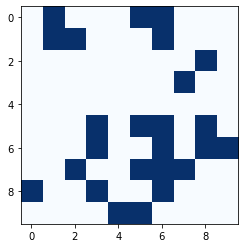

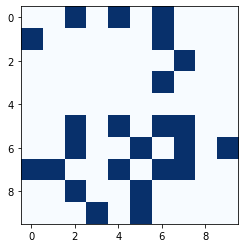

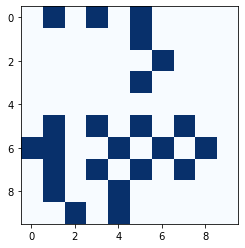

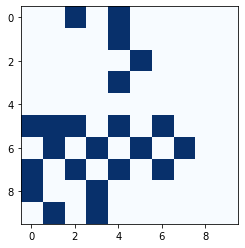

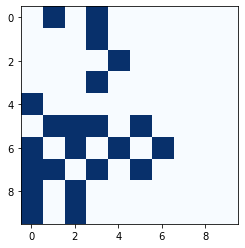

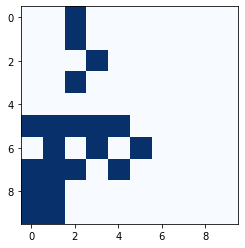

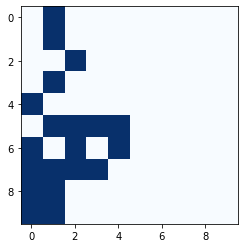

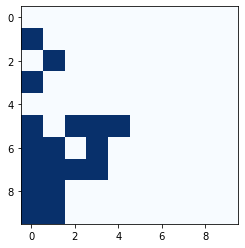

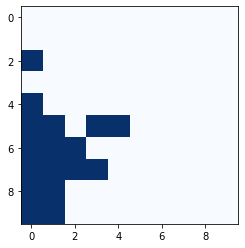

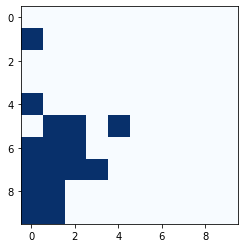

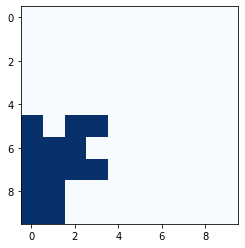

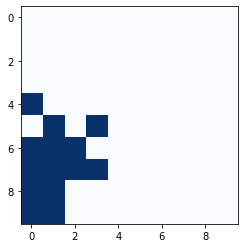

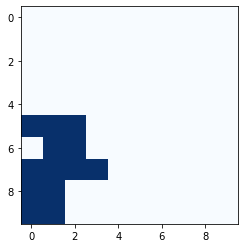

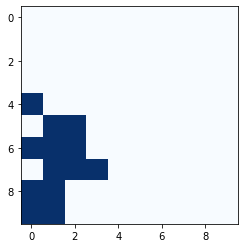

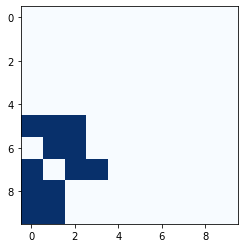

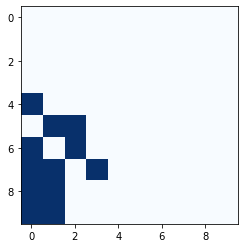

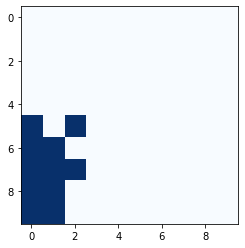

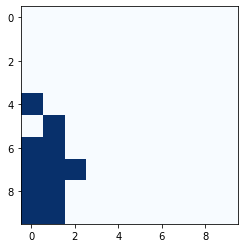

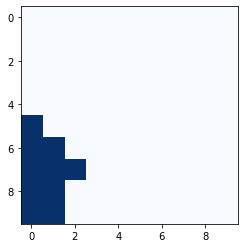

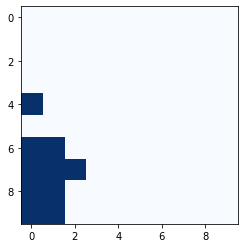

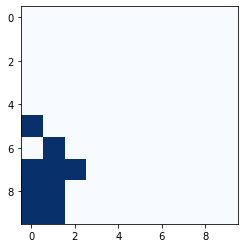

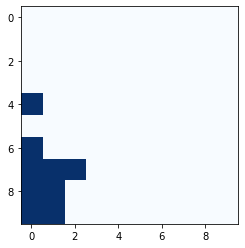

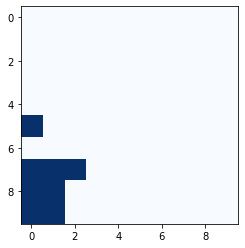

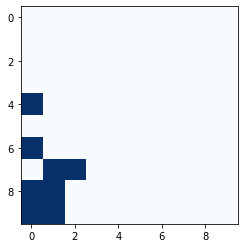

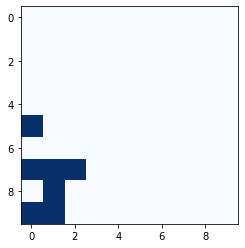

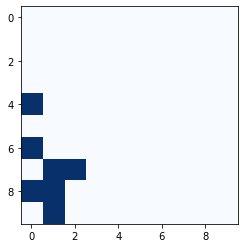

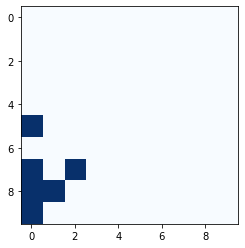

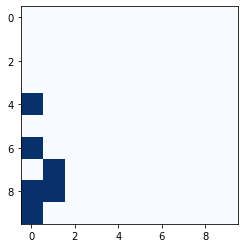

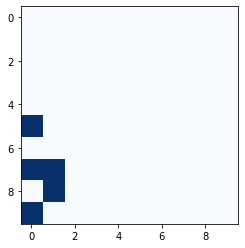

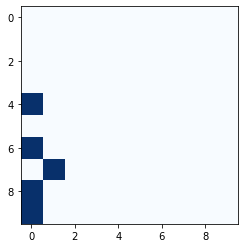

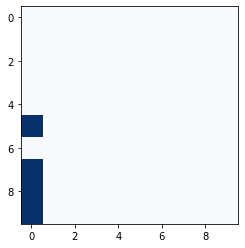

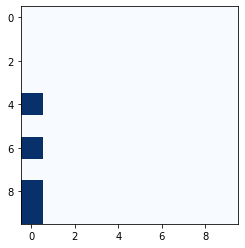

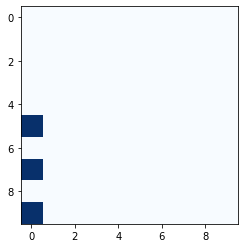

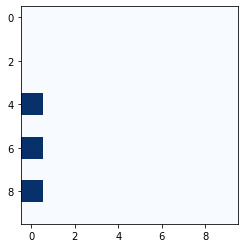

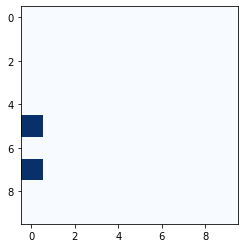

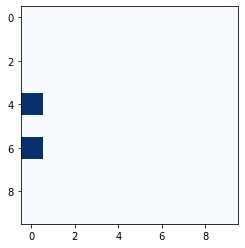

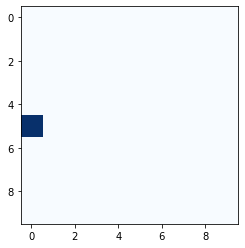

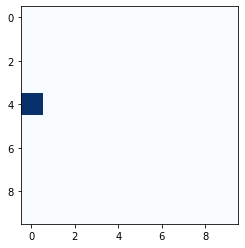

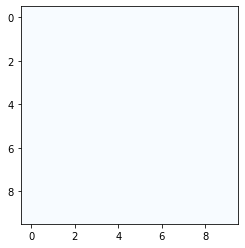

In [237]:
t = Crowd_Egress(25,3,1,(10,10))
t.initialize()

j = 0
while np.count_nonzero(t.room_setup) != 0:
    j += 1
    if j % 10 == 0:
        plt.imshow(t.room_setup, cmap="Blues")
        t.update()
        plt.show()
plt.imshow(t.room_setup, cmap="Blues")
t.room_setup
plt.show()

## Different Number of Exits ##

### Histogram ###

Text(0, 0.5, 'Frequency')

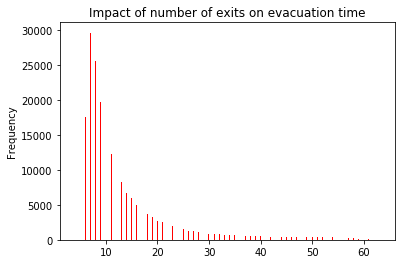

In [136]:
"""
This simulation is a test of different number of exits impact the time it 
takes for people to evacuate the room.
The number of exits are varied from 1 to 20 for a scenrio of 30 people in a 10x10 room size
where the size of exit is 1 coordinate. 

Each step is counted as one interval in this scenario. 

"""

multi_exits = [e for e in range(1,21)]
counts = []
for i in range(1000):
  for m in multi_exits:
    c = 0
    exit_test = Crowd_Egress(30,m,1,(10,10))
    exit_test.initialize()
    while np.count_nonzero(exit_test.room_setup) != 0:
      exit_test.update()
      c+=1
    counts.append(c)

#number of bins is a square root of the number of data points rounded up
plt.hist(counts, bins = int(sqrt(len(counts))), color = "red")
plt.title("Impact of number of exits on evacuation time")
plt.ylabel("Frequency")

### Confidence Intervals and Descriptive Stats###

In [234]:
print("CI:", stats.t.interval(0.95, len(counts)-1, loc=np.mean(counts), scale=stats.sem(counts)))
stats.describe(counts)



CI: (13.478059897258296, 13.564210102741702)


DescribeResult(nobs=200000, minmax=(4, 63), mean=13.521135, variance=96.60090631630658, skewness=2.362609825594367, kurtosis=5.845180156617454)

### Plot ###

Text(0, 0.5, 'Time Taken to Evacuate')

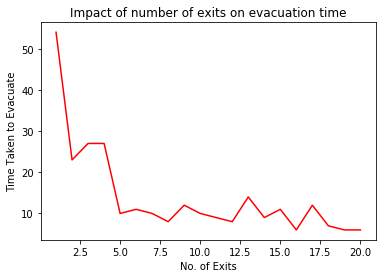

In [135]:
multi_exits = [e for e in range(1,21)]
counts = []
for i in range(1):
  for m in multi_exits:
    c = 0
    exit_test = Crowd_Egress(30,m,1,(10,10))
    exit_test.initialize()
    while np.count_nonzero(exit_test.room_setup) != 0:
      exit_test.update()
      c+=1
    counts.append(c)

#number of bins is a square root of the number of data points rounded up
plt.plot(multi_exits,counts, color = "red")
plt.title("Impact of number of exits on evacuation time")
plt.xlabel("No. of Exits")
plt.ylabel("Time Taken to Evacuate")

## Different Number of People in the Room ##

### Histogram ###

Text(0, 0.5, 'Frequency')

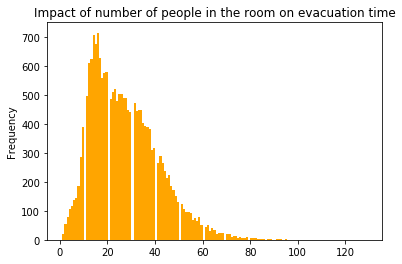

In [239]:
"""
This simulation is a test of different number of people impact the time it 
takes for people to evacuate the room.
The number of people are varied from 1 to 100 with a step size of 5 for a scenrio of 3 exits in a 15x15 room size
where the size of exit is 1 coordinate. 

"""
peeps = [p for p in range(1,101,5)]
counts_p = []
for i in range(1000):
  for n in peeps:
    c = 0
    people_test = Crowd_Egress(n,5,1,(15,15))
    people_test.initialize()
    while np.count_nonzero(people_test.room_setup) != 0:
      people_test.update()
      c+=1
    counts_p.append(c)

plt.hist(counts_p, bins = int(sqrt(len(counts_p))), color = "orange")
plt.title("Impact of number of people in the room on evacuation time")
plt.ylabel("Frequency")

### Confidence Intervals and Descriptive Stats ### 

In [240]:
print ("CI:", stats.t.interval(0.95, len(counts_p)-1, loc=np.mean(counts_p), scale=stats.sem(counts_p)))
stats.describe(counts_p)

CI: (27.041084986570976, 27.433015013429024)


DescribeResult(nobs=20000, minmax=(1, 129), mean=27.23705, variance=199.91175288514424, skewness=0.8281919125432498, kurtosis=0.8031407723844088)

### Plot ### 

Text(0, 0.5, 'Time Taken to Evacuate')

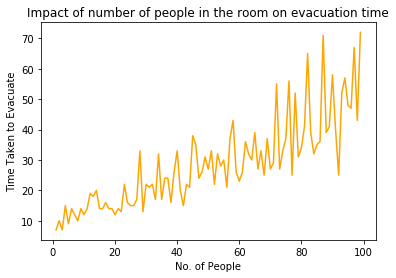

In [146]:
peeps = [p for p in range(1,100)]
counts_p = []
for i in range(1):
  for n in peeps:
    c = 0
    people_test = Crowd_Egress(n,5,1,(15,15))
    people_test.initialize()
    while np.count_nonzero(people_test.room_setup) != 0:
      people_test.update()
      c+=1
    counts_p.append(c)

plt.plot(peeps,counts_p, color = "orange")
plt.title("Impact of number of people in the room on evacuation time")
plt.xlabel("No. of People")
plt.ylabel("Time Taken to Evacuate")

## Different Room Dimensions ## 

### Histogram ### 

Text(0, 0.5, 'Frequency')

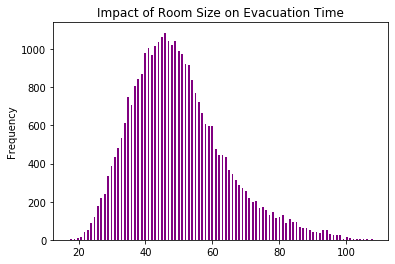

In [241]:
"""
This simulation is a test of different how room sizes impact the time it 
takes for people to evacuate the room.
The dimensions of a square room are varied from 8x8 to 40x40 grid for a scenario of 2 exits
where the size of exit is 2 coordinates. 

"""
dims = [d for d in range(8,41)]
counts_d = []
for i in range(1000):
  for dd in dims:
    c = 0
    dim_test = Crowd_Egress(50,2,2,(dd,dd))
    dim_test.initialize()
    while np.count_nonzero(dim_test.room_setup) != 0:
      dim_test.update()
      c+=1
    counts_d.append(c)

plt.hist(counts_d, bins = int(sqrt(len(counts_d))), color = "purple")
plt.title("Impact of Room Size on Evacuation Time")
plt.ylabel("Frequency")

### Confidence Intervals and Descriptive Stats ###

In [242]:
print ("CI:", stats.t.interval(0.95, len(counts_d)-1, loc=np.mean(counts_d), scale=stats.sem(counts_d)))
stats.describe(counts_d)

CI: (49.67825404836171, 49.97677625466859)


DescribeResult(nobs=33000, minmax=(17, 108), mean=49.82751515151515, variance=191.37235116950285, skewness=0.7673997554900981, kurtosis=0.653136562690301)

### Plot ###

Text(0, 0.5, 'Time Taken to Evacuate')

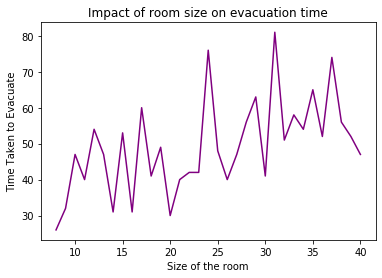

In [164]:
dims = [d for d in range(8,41)]
counts_d = []
for i in range(1):
  for dd in dims:
    c = 0
    dim_test = Crowd_Egress(50,2,2,(dd,dd))
    dim_test.initialize()
    while np.count_nonzero(dim_test.room_setup) != 0:
      dim_test.update()
      c+=1
    counts_d.append(c)
plt.plot(dims,counts_d, color = "purple")
plt.title("Impact of room size on evacuation time")
plt.xlabel("Size of the room")
plt.ylabel("Time Taken to Evacuate")

## Effect of Exit Size ##

### Histogram ### 

Text(0, 0.5, 'Frequency')

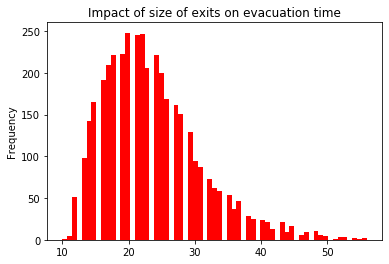

In [247]:
"""
This simulation is a test of different number of exits impact the time it 
takes for people to evacuate the room.
The number of exits are varied from 1 to 20 for a scenrio of 30 people in a 10x10 room size
where the size of exit is 1 coordinate. 

Each step is counted as one interval in this scenario. 

"""

sizes = [e for e in range(1,5)]
counts_es = []
for i in range(1000):
  for a in sizes:
    c = 0
    exitsize_test = Crowd_Egress(30,2,a,(10,10))
    exitsize_test.initialize()
    while np.count_nonzero(exitsize_test.room_setup) != 0:
      exitsize_test.update()
      c+=1
    counts_es.append(c)

#number of bins is a square root of the number of data points rounded up
plt.hist(counts_es, bins = int(sqrt(len(counts_es))), color = "red")
plt.title("Impact of size of exits on evacuation time")
plt.ylabel("Frequency")

### Confidence Intervals and Descriptive Stats ###

In [248]:
print ("CI:", stats.t.interval(0.95, len(counts_es)-1, loc=np.mean(counts_es), scale=stats.sem(counts_es)))
stats.describe(counts_es)

CI: (23.31789260257624, 23.77610739742376)


DescribeResult(nobs=4000, minmax=(10, 56), mean=23.547, variance=54.623446861715436, skewness=1.0004419233870525, kurtosis=1.1852380065288282)

### Plot ###

Text(0, 0.5, 'Time Taken to Evacuate')

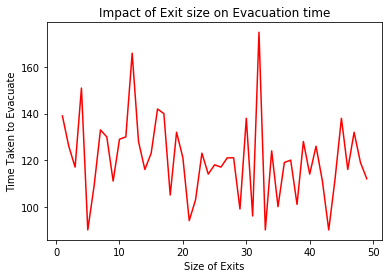

In [158]:
sizes = [e for e in range(1,50)]
counts_es = []
for i in range(1):
  for a in sizes:
    c = 0
    exitsize_test = Crowd_Egress(30,2,a,(100,100))
    exitsize_test.initialize()
    while np.count_nonzero(exitsize_test.room_setup) != 0:
      exitsize_test.update()
      c+=1
    counts_es.append(c)
plt.plot(sizes,counts_es, color = "red")
plt.title("Impact of Exit size on Evacuation time")
plt.xlabel("Size of Exits")
plt.ylabel("Time Taken to Evacuate")

### Histograms For Different Numbers of people in the room and evacuation time ###

In [186]:
#30 people 

times=[]
for i in range(1000):
    c = 0
    people_test = Crowd_Egress(30,2,1,(10,10))
    people_test.initialize()
    while np.count_nonzero(people_test.room_setup) != 0:
      people_test.update()
      c+=1
    times.append(c)



In [200]:
#50 people
times1=[]
for i in range(1000):
    c = 0
    people_test = Crowd_Egress(50,2,1,(10,10))
    people_test.initialize()
    while np.count_nonzero(people_test.room_setup) != 0:
      people_test.update()
      c+=1
    times1.append(c)


In [201]:
#70 people
times2=[]
for i in range(1000):
    c = 0
    people_test = Crowd_Egress(70,2,1,(10,10))
    people_test.initialize()
    while np.count_nonzero(people_test.room_setup) != 0:
      people_test.update()
      c+=1
    times2.append(c)

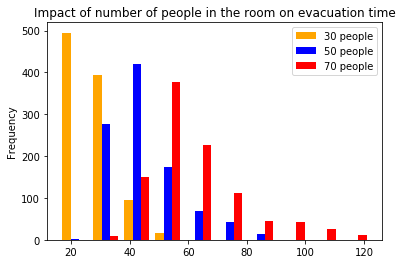

In [202]:
d = [times, times1, times2]
plt.hist(d, color = ["orange","blue","red"])
plt.title("Impact of number of people in the room on evacuation time")
plt.ylabel("Frequency")
legend = ["30 people", "50 people", "70 people"]
plt.legend(legend)

### Histograms for no. of exits in a room ###

In [212]:
#1 exit in the room 
cts = []
for i in range(1000):
    c = 0
    exit_test = Crowd_Egress(30,1,1,(10,10))
    exit_test.initialize()
    while np.count_nonzero(exit_test.room_setup) != 0:
      exit_test.update()
      c+=1
    cts.append(c)

In [213]:
#3 exits in the room 
cts1 = []
for i in range(1000):
    c = 0
    exit_test = Crowd_Egress(30,3,1,(10,10))
    exit_test.initialize()
    while np.count_nonzero(exit_test.room_setup) != 0:
      exit_test.update()
      c+=1
    cts1.append(c)

In [214]:
#5 exits in the room 
cts2 = []
for i in range(1000):
    c = 0
    exit_test = Crowd_Egress(30,5,1,(10,10))
    exit_test.initialize()
    while np.count_nonzero(exit_test.room_setup) != 0:
      exit_test.update()
      c+=1
    cts2.append(c)

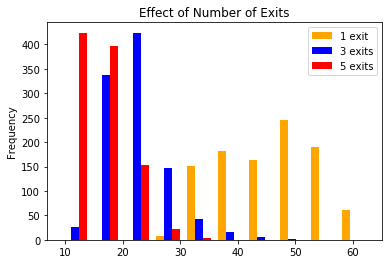

In [215]:
cs = [cts, cts1, cts2]
plt.hist(cs, color = ["orange","blue","red"])
plt.title("Effect of Number of Exits")
plt.ylabel("Frequency")
legend = ["1 exit", "3 exits", "5 exits"]
plt.legend(legend)

### Histogram for effects of exit size ###

In [196]:
#exit size = 1
t = []
for i in range(1000):
    c = 0
    exitsize_test = Crowd_Egress(30,2,1,(10,10))
    exitsize_test.initialize()
    while np.count_nonzero(exitsize_test.room_setup) != 0:
      exitsize_test.update()
      c+=1
    t.append(c)

In [197]:
#exit size = 2
t1 = []
for i in range(1000):
    c = 0
    exitsize_test = Crowd_Egress(30,2,2,(10,10))
    exitsize_test.initialize()
    while np.count_nonzero(exitsize_test.room_setup) != 0:
      exitsize_test.update()
      c+=1
    t1.append(c)

In [198]:
#exit size = 3
t2 = []
for i in range(1000):
    c = 0
    exitsize_test = Crowd_Egress(30,2,3,(10,10))
    exitsize_test.initialize()
    while np.count_nonzero(exitsize_test.room_setup) != 0:
      exitsize_test.update()
      c+=1
    t2.append(c)

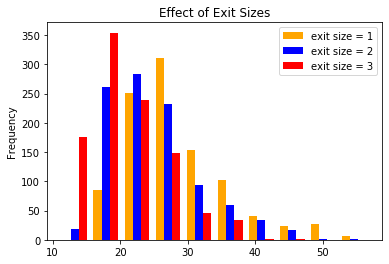

In [217]:
d = [t, t1, t2]
plt.hist(d, color = ["orange","blue","red"])
plt.title("Effect of Exit Sizes")
plt.ylabel("Frequency")
legend = ["exit size = 1", "exit size = 2", "exit size = 3"]
plt.legend(legend)